In [3]:
import os
import warnings
import pandas as pd
import networkx as nx
import matplotlib as mpl
from empiricaldist import Cdf
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from bokeh.plotting import figure
import matplotlib.colors as mcolors
from utils import decorate, savefig
from bokeh.transform import linear_cmap
from bokeh.plotting import from_networkx
from bokeh.io import output_notebook, show, save
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8,Inferno
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, ColorBar, LabelSet, LogColorMapper

# Hyderabad

In [4]:
#caricamento network
edgelist = pd.read_csv("hbn.txt",sep="	",header=None)
edgelist=edgelist.drop(edgelist.iloc[:, [3,4]], axis=1)
edgelist.columns=["Source","Target","Weight"]
#network pesata
G_pesato = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph(), source="Source", target="Target", edge_attr=["Weight"])
#network non pesata
G_non_pesato = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph(), source="Source", target="Target", edge_attr=None)
#lista di nodi
nodi= edgelist["Source"].unique()
df_nodi= pd.DataFrame(nodi)
df_nodi=df_nodi.rename(columns={0:"id"})
#creazione data frame network
data = df_nodi.set_index('id').to_dict('index').items()
G_non_pesato.add_nodes_from(data)
G_pesato.add_nodes_from(data)
print('NODI:\n',len(G_pesato.nodes))
print('\nLINKS:\n',len(G_pesato.edges))

NODI:
 1085

LINKS:
 2951


# Matrice di Adiacenza

In [5]:
nodelist = list(G_pesato.nodes)
mat_adj = nx.to_pandas_adjacency(G_pesato, dtype=int)
mat_adj

Afzalgunj.Bus.Stop  CBS.Bus.Stop  Charminar.Bus.Stop  \
Afzalgunj.Bus.Stop                   0             1                   1   
CBS.Bus.Stop                         1             0                   1   
Charminar.Bus.Stop                   1             1                   0   
LB.Nagar.Bus.Stop                    1             0                   0   
Malakpet                             1             0                   0   
...                                ...           ...                 ...   
Kesaram                              0             0                   0   
MC.Pally                             0             0                   0   
Ram.Lingampally                      0             0                   0   
Gopalapuram                          0             0                   0   
Veldurthi                            0             0                   0   

                    LB.Nagar.Bus.Stop  Malakpet  Chaderghat.Bus.Stop  \
Afzalgunj.Bus.Stop                  1         1                    1   
CBS.Bus.Stop                        0         0                    1   
Charminar.Bus.Stop                  0         0                    0   
LB.Nagar.Bus.Stop                   0         0                    0   
Malakpet                            0         0                    1   
...                               ...       ...                  ...   
Kesaram                             0         0                    0   
MC.Pally                            0         0                    0   
Ram.Lingampally                     0         0                    0   
Gopalapuram                         0         0                    0   
Veldurthi                           0         0                    0   

                    Womens.college.Bus.Stop  NGOs.Colony.Bus.Stop  \
Afzalgunj.Bus.Stop                        1                     1   
CBS.Bus.Stop                              0                     0   
Charminar.Bus.Stop                        0                     0   
LB.Nagar.Bus.Stop                         0                     0   
Malakpet                                  0                     0   
...                                     ...                   ...   
Kesaram                                   0                     0   
MC.Pally                                  0                     0   
Ram.Lingampally                           0                     0   
Gopalapuram                               0                     0   
Veldurthi                                 0                     0   

                    East.Bahadurpura  Falaknuma  ...  Fakeerguda  Canaranagar  \
Afzalgunj.Bus.Stop                 1          1  ...           0            0   
CBS.Bus.Stop                       0          0  ...           0            0   
Charminar.Bus.Stop                 1          0  ...           0            0   
LB.Nagar.Bus.Stop                  0          0  ...           0            0   
Malakpet                           0          0  ...           0            0   
...                              ...        ...  ...         ...          ...   
Kesaram                            0          0  ...           0            0   
MC.Pally                           0          0  ...           0            0   
Ram.Lingampally                    0          0  ...           0            0   
Gopalapuram                        0          0  ...           0            0   
Veldurthi                          0          0  ...           0            0   

                    G.Madanna.Gudem  B.Pally(Gopalpuram)  Bhongir.Bus.Stop  \
Afzalgunj.Bus.Stop                0                    0                 0   
CBS.Bus.Stop                      0                    0                 0   
Charminar.Bus.Stop                0                    0                 0   
LB.Nagar.Bus.Stop                 0                    0                 0   
Malakpet                          0               

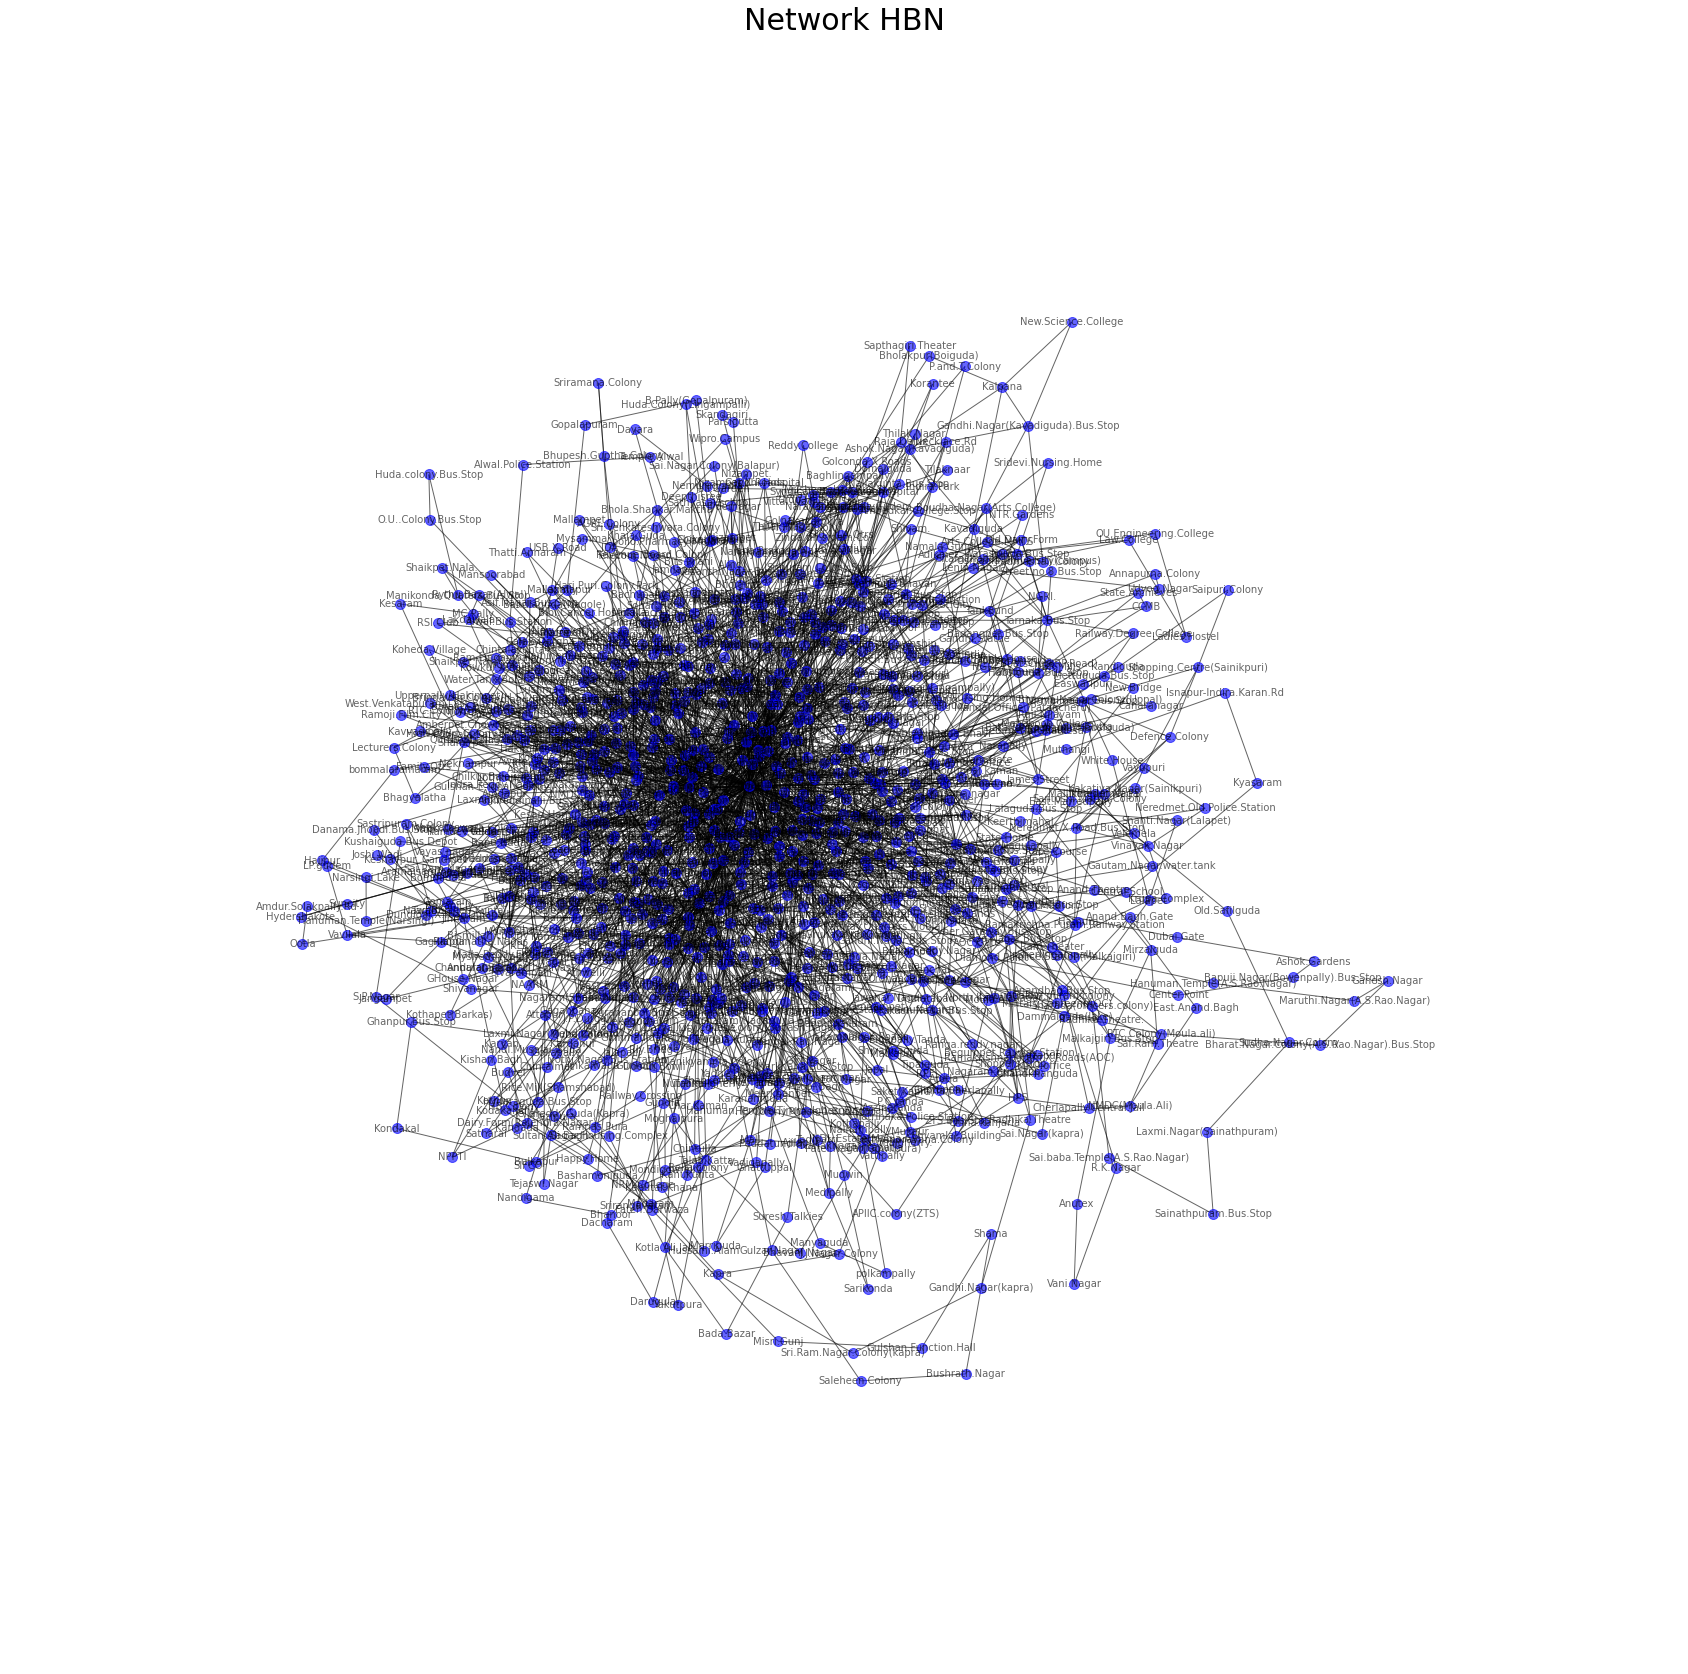

In [6]:
pos = nx.spring_layout(G_pesato, k=0.1)
plt.rcParams["figure.figsize"] = (30,30)
nx.draw_networkx(G_pesato, pos=pos, node_size=100, edge_color="black", alpha=0.6, with_labels=True,
                node_color="blue",font_size=10,font_color="black")
plt.title("Network HBN", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

# Large Scale

In [7]:
#La rete è connesssa?
print('\nNetwork is connected?\n',nx.is_connected(G_pesato))                          
comps = sorted(nx.connected_components(G_pesato),
               key=len, reverse=True)



Network is connected?
 True


In [8]:
#average path length
apl=[]
apl.append((round(nx.average_shortest_path_length(G_non_pesato),3)))
apl.append((round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
df=pd.DataFrame([apl],columns=["Network non pesata","Network pesata"])
#diametro
diametro=[]
diametro.append(nx.diameter(G_non_pesato))
diametro.append(nx.diameter(G_pesato))
df_length = len(df)
df.loc[df_length] = diametro
#density
density=[]
density.append(round(nx.density(G_non_pesato),4))
density.append(round(nx.density(G_pesato),4))
df_length = len(df)
df.loc[df_length] = density
# average local clustering
alc=[]
alc.append(round(nx.average_clustering(G_non_pesato),4))
alc.append(round(nx.average_clustering(G_pesato,weight='Weight'),4))
df_length = len(df)
df.loc[df_length] = alc
#global clustering
global_clustering=[]
global_clustering.append(round(nx.transitivity(G_non_pesato),3))
global_clustering.append(round(nx.transitivity(G_pesato),3))
df_length = len(df)
df.loc[df_length] = global_clustering
indici=["Average Path Length","Diametro","Density","Average Local Clustering","Global Clustering"]
df.index =indici
df

Network non pesata  Network pesata
Average Path Length                   3.8770          6.6790
Diametro                             11.0000         11.0000
Density                               0.0050          0.0050
Average Local Clustering              0.2597          0.0095
Global Clustering                     0.1020          0.1020

# Small scale

In [9]:
#calcolo del grado per la network pesata e non pesata
nx.set_node_attributes(G_non_pesato, name='unweighted_degree', values=dict(nx.degree(G_non_pesato)))
nx.set_node_attributes(G_pesato, name='unweighted_degree', values=dict(nx.degree(G_pesato)))
nx.set_node_attributes(G_pesato, name='weighted_degree', values=dict(nx.degree(G_pesato, weight='Weight')))

#calcolo degree centrality
nx.set_node_attributes(G_non_pesato, name='degree_centrality', values=nx.degree_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='degree_centrality', values=nx.degree_centrality(G_pesato))

#calcolo betweeness centrality
nx.set_node_attributes(G_non_pesato, name='betweenness', values=nx.betweenness_centrality(G_non_pesato, normalized=True))
nx.set_node_attributes(G_pesato, name='betweenness', values=nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight"))

#calcolo closeness
nx.set_node_attributes(G_non_pesato, name='closeness', values=nx.closeness_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='closeness', values=nx.closeness_centrality(G_pesato))

#calcolo eigenvector
nx.set_node_attributes(G_non_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_pesato, weight="Weight"))

#calcolo page rank
nx.set_node_attributes(G_non_pesato, name='page_rank', values=nx.pagerank(G_non_pesato))
nx.set_node_attributes(G_pesato, name='page_rank', values=nx.pagerank(G_pesato, weight="Weight"))

In [10]:
unweightedDF = pd.DataFrame(dict(G_non_pesato.nodes(data=True))).T
unweightedDF

unweighted_degree  degree_centrality  betweenness  \
Afzalgunj.Bus.Stop               66.0           0.060886     0.077752   
CBS.Bus.Stop                     17.0           0.015683     0.003498   
Charminar.Bus.Stop               68.0           0.062731     0.095651   
LB.Nagar.Bus.Stop                30.0           0.027675     0.018860   
Malakpet                         14.0           0.012915     0.003088   
...                               ...                ...          ...   
Kesaram                           2.0           0.001845     0.000009   
MC.Pally                          2.0           0.001845     0.000464   
Ram.Lingampally                   2.0           0.001845     0.000022   
Gopalapuram                       2.0           0.001845     0.000053   
Veldurthi                         2.0           0.001845     0.000346   

                    closeness  eigenvector  page_rank  
Afzalgunj.Bus.Stop   0.395620     0.213144   0.008965  
CBS.Bus.Stop         0.327889     0.079725   0.002168  
Charminar.Bus.Stop   0.383717     0.185046   0.009593  
LB.Nagar.Bus.Stop    0.344674     0.085368   0.004113  
Malakpet             0.313023     0.052593   0.001749  
...                       ...          ...        ...  
Kesaram              0.198099     0.000331   0.000518  
MC.Pally             0.243870     0.001525   0.000516  
Ram.Lingampally      0.244199     0.001722   0.000501  
Gopalapuram          0.199632     0.000180   0.000599  
Veldurthi            0.283103     0.010451   0.000453  

[1085 rows x 6 columns]

In [11]:
weightedDF = pd.DataFrame(dict(G_pesato.nodes(data=True))).T
weightedDF.sort_values("eigenvector",ascending=False)

unweighted_degree  weighted_degree  \
Clock.Tower                              7.0            248.0   
Secunderabad.Junction                  183.0            554.0   
patny                                   14.0            279.0   
Sangeeth                                 9.0            117.0   
Paradise.Bus.Stop                       19.0            208.0   
...                                      ...              ...   
Kyasaram                                 2.0              2.0   
Laxmi.Nagar(Sainathpuram)                2.0              4.0   
Bushrath.Nagar                           2.0              4.0   
Sudha.Nagar.Colony                       2.0              4.0   
Shama                                    2.0              4.0   

                           degree_centrality  betweenness  closeness  \
Clock.Tower                         0.006458     0.002084   0.322427   
Secunderabad.Junction               0.168819     0.477206   0.468858   
patny                               0.012915     0.004785   0.325428   
Sangeeth                            0.008303     0.003222   0.325233   
Paradise.Bus.Stop                   0.017528     0.026398   0.329884   
...                                      ...          ...        ...   
Kyasaram                            0.001845     0.000030   0.174333   
Laxmi.Nagar(Sainathpuram)           0.001845     0.005525   0.142594   
Bushrath.Nagar                      0.001845     0.000296   0.152376   
Sudha.Nagar.Colony                  0.001845     0.007360   0.142895   
Shama                               0.001845     0.000015   0.134575   

                            eigenvector  page_rank  
Clock.Tower                5.720141e-01   0.006065  
Secunderabad.Junction      5.059099e-01   0.019903  
patny                      4.819991e-01   0.005787  
Sangeeth                   2.362641e-01   0.003180  
Paradise.Bus.Stop          2.220059e-01   0.003771  
...                                 ...        ...  
Kyasaram                   2.138586e-09   0.000634  
Laxmi.Nagar(Sainathpuram)  7.524557e-10   0.000729  
Bushrath.Nagar             2.005305e-10   0.000816  
Sudha.Nagar.Colony         3.812744e-11   0.000733  
Shama                      2.680786e-11   0.000811  

[1085 rows x 7 columns]

# Degree

In [12]:
topNodes = 15
unweightedDF["Label"]=unweightedDF.index
weightedDF["Label"]=weightedDF.index

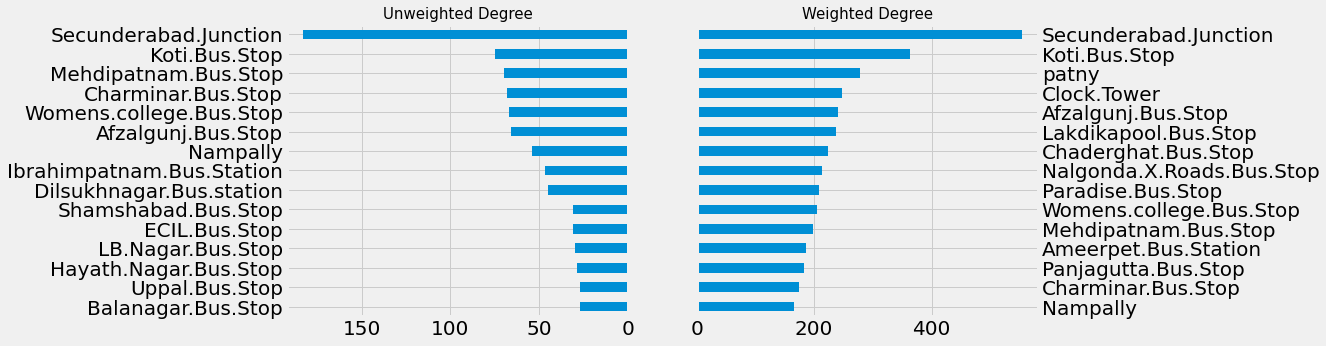

In [45]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='unweighted_degree', ascending=False)[:topNodes].plot(x='Label', y='unweighted_degree', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted Degree", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='weighted_degree', ascending=False)[:topNodes].plot(x='Label', y='weighted_degree', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted Degree", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

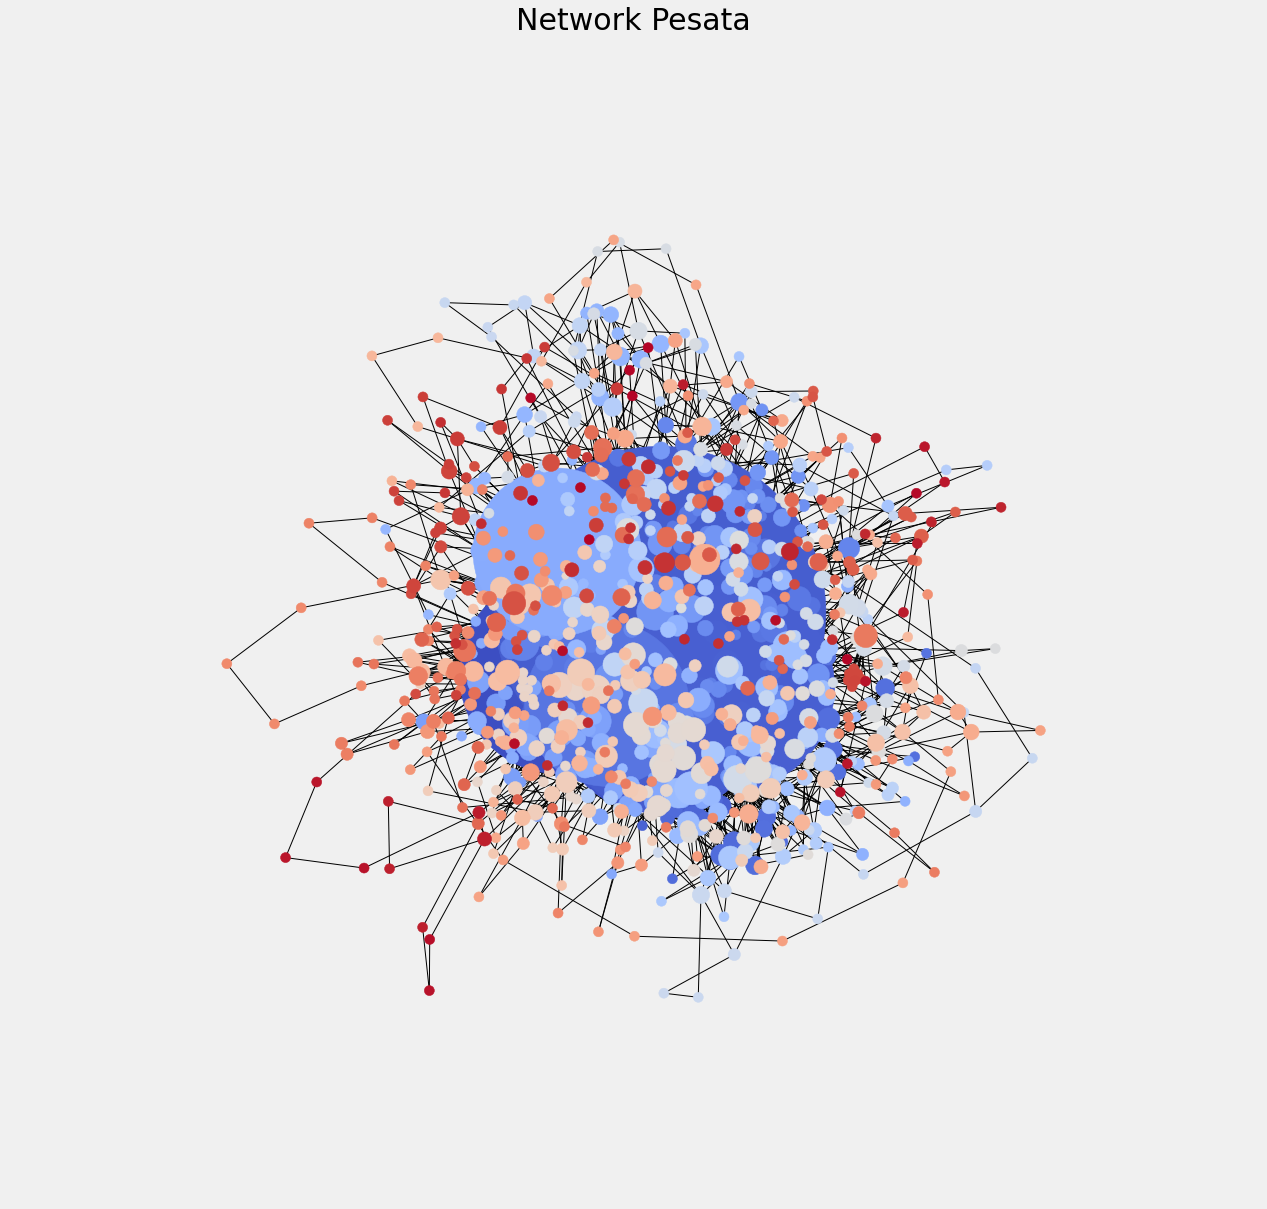

In [14]:
pos = nx.spring_layout(G_pesato, k=0.1)
color_lookup = {k:v for v, k in enumerate(sorted(set(G_pesato.nodes())))}
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
node_colors = [mapper.to_rgba(i) for i in color_lookup.values()]
d = dict(list(nx.degree(G_pesato)))
node_sizes = [v*50 if v <= 30 else v*600 for v in d.values()]
plt.rcParams["figure.figsize"] = (20,20)
nx.draw_networkx(G_pesato, pos=pos, node_size=node_sizes, node_color=node_colors, edge_color="black", with_labels=False, font_size=12)
plt.title("Network Pesata", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

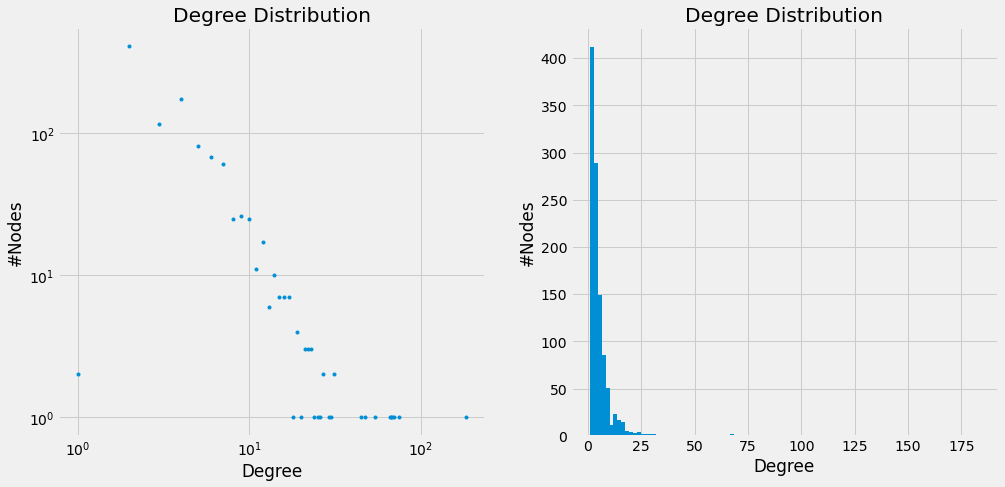

In [15]:
hist = nx.degree_histogram(G_pesato)

plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist)), hist,'.')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

degree_sequence = [G_pesato.degree(n) for n in G_pesato.nodes]

plt.subplot(1, 2, 2)
counts, bins, patches = plt.hist(degree_sequence,bins=100)

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

In [16]:
#creazione di un dataframe per una visualizzazione più rapida dei vari gradi e le relative frequenze
degree_counts = Counter(degree_sequence)
sorted_degree = sorted(degree_counts.items(), 
                       key=lambda item: item[1],reverse=True)
list_gradi=[]
conteggi=[]
for i in range(len(sorted_degree)):
    list_gradi.append(sorted_degree[i][0])
    conteggi.append(sorted_degree[i][1])
df_conteggi=pd.DataFrame(list_gradi,columns=["Grado"])
df_conteggi['Frequenze']=conteggi
df_conteggi


Grado  Frequenze
0       2        410
1       4        173
2       3        116
3       5         81
4       6         68
5       7         61
6       9         26
7       8         25
8      10         25
9      12         17
10     11         11
11     14         10
12     17          7
13     15          7
14     16          7
15     13          6
16     19          4
17     22          3
18     21          3
19     23          3
20     31          2
21     27          2
22      1          2
23     66          1
24     68          1
25     30          1
26     67          1
27     54          1
28     25          1
29     29          1
30     75          1
31    183          1
32     70          1
33     26          1
34     20          1
35     45          1
36     24          1
37     47          1
38     18          1

# Degree Centrality

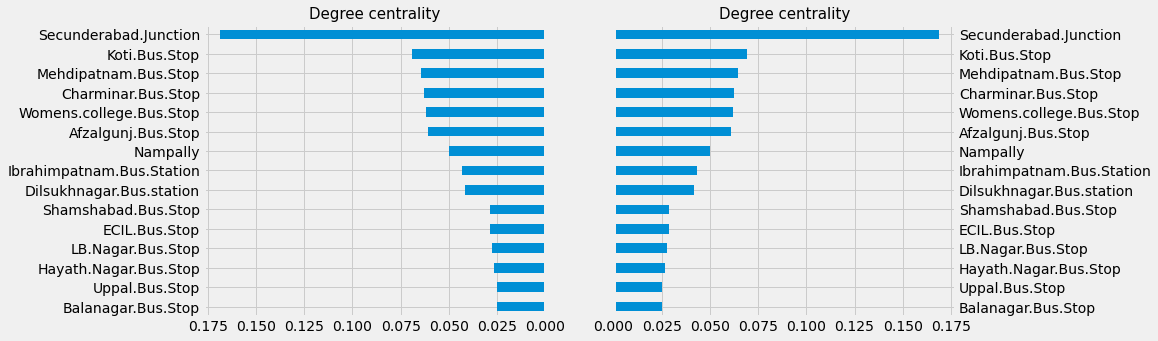

In [17]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Degree centrality", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Degree centrality", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [18]:
if not os.path.isdir('img_hbn'):
    os.mkdir('img_hbn')
title = 'Degree centrality'
adjusted_node_size = dict([(node, 5+degree*175) for node, degree in nx.degree_centrality(G_pesato).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("degree_centrality","@degree_centrality")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.degree_centrality(G_pesato).values()), high=max(nx.degree_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Degree centrality.html'

# Betweenness


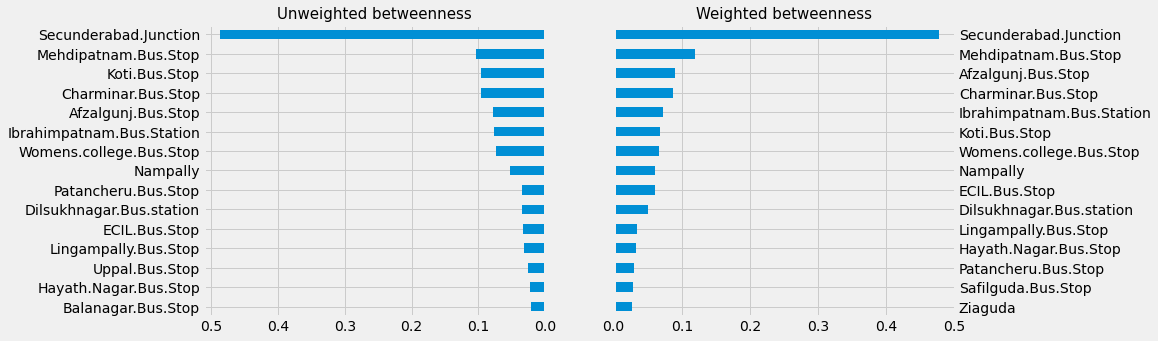

In [19]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted betweenness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted betweenness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

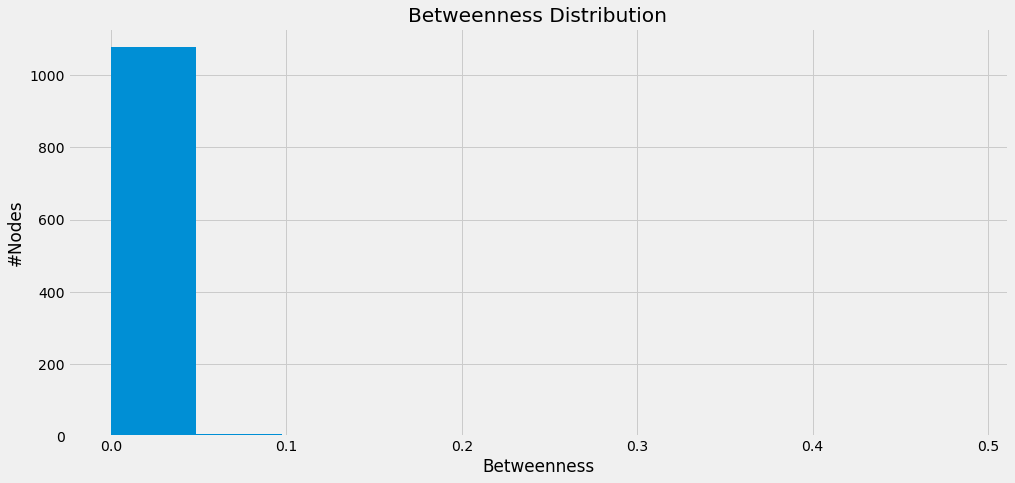

In [20]:
#grafico della distribuzione di frequenze per la betweenness
B = nx.betweenness_centrality(G_pesato,normalized=True)
betweenness_sequence = list(B.values())

counts, bins, patches = plt.hist(betweenness_sequence,bins=10)
plt.title("Betweenness Distribution")
plt.xlabel("Betweenness")
plt.ylabel("#Nodes")
plt.show()

In [21]:
if not os.path.isdir('img_hbn'):             
    os.mkdir('img_hbn')
title = 'Weighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight").values()), high=max(nx.betweenness_centrality(G_pesato, weight="Weight",normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Weighted betweenness.html'

In [22]:
if not os.path.isdir('img_hbn'):             
    os.mkdir('img_hbn')
title = 'Unweighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_non_pesato, normalized=True).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_non_pesato, normalized=True).values()), high=max(nx.betweenness_centrality(G_non_pesato, normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Unweighted betweenness.html'

# Closeness

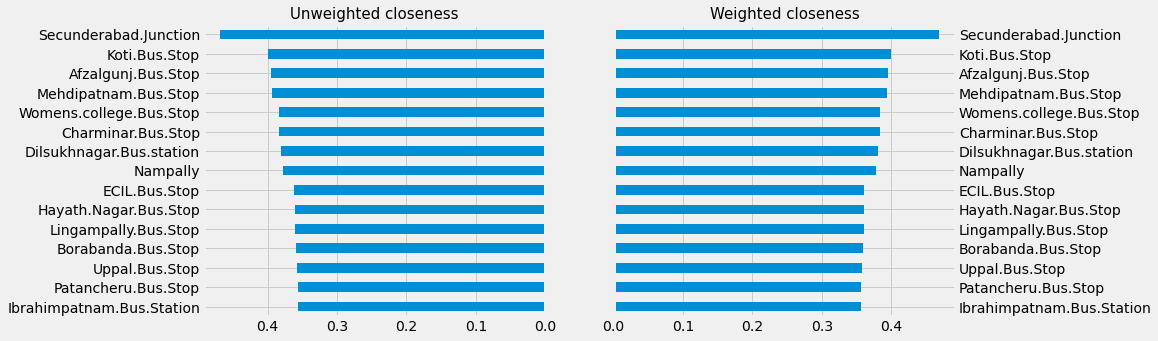

In [23]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted closeness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted closeness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [24]:
if not os.path.isdir('img_hbn'):             
    os.mkdir('img_hbn')
title = 'Closeness'
adjusted_node_size = dict([(node, 5+closeness*15) for node, closeness in nx.closeness_centrality(G_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("closeness","@closeness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.closeness_centrality(G_pesato).values()), high=max(nx.closeness_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Closeness.html'

# Eigenvector

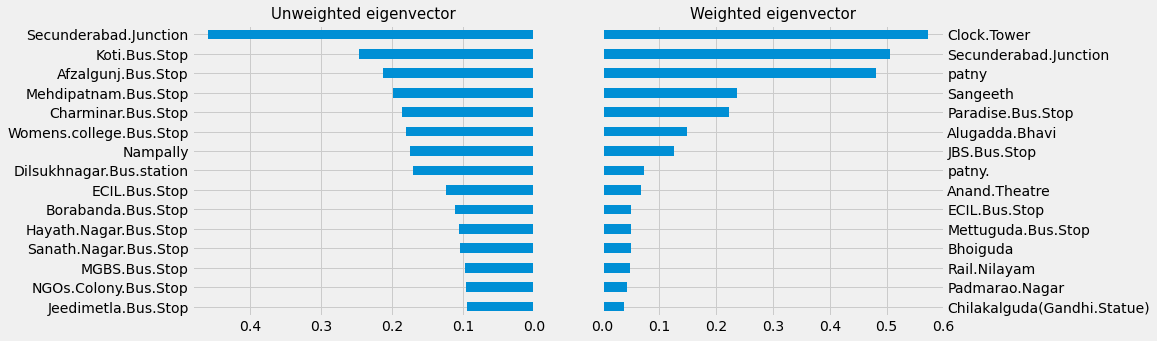

In [25]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted eigenvector", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted eigenvector", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [26]:
if not os.path.isdir('img_hbn'):             
    os.mkdir('img_hbn')
title = 'Weighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_pesato,weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_pesato,weight="Weight").values()), high=max(nx.eigenvector_centrality(G_pesato,weight="Weight").values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Weighted Eigenvector.html'

In [27]:
if not os.path.isdir('img_hbn'):             
    os.mkdir('img_hbn')
title = 'Unweighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_non_pesato).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_non_pesato).values()), high=max(nx.eigenvector_centrality(G_non_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Unweighted Eigenvector.html'

# Page Rank


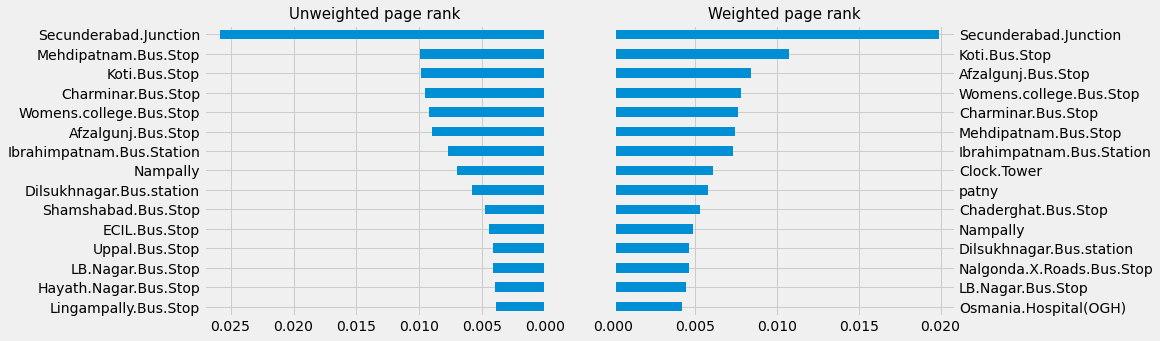

In [28]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted page rank", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted page rank", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [29]:
if not os.path.isdir('img_hbn'):             
    os.mkdir('img_hbn')
title = 'Weighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*350) for node, page_rank in nx.pagerank(G_pesato, weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_pesato, weight="Weight").values()), high=max(nx.pagerank(G_pesato, weight="Weight").values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Weighted Pagerank.html'

In [30]:
if not os.path.isdir('img_hbn'):             
    os.mkdir('img_hbn')
title = 'Unweighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*350) for node, page_rank in nx.pagerank(G_non_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_non_pesato).values()), high=max(nx.pagerank(G_non_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_hbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_hbn\\Unweighted Pagerank.html'

# Medium Scale

In [46]:
# Find k-cores
G_core_6= nx.k_core(G_pesato, 6)
G_core_7 = nx.k_core(G_pesato, 7)

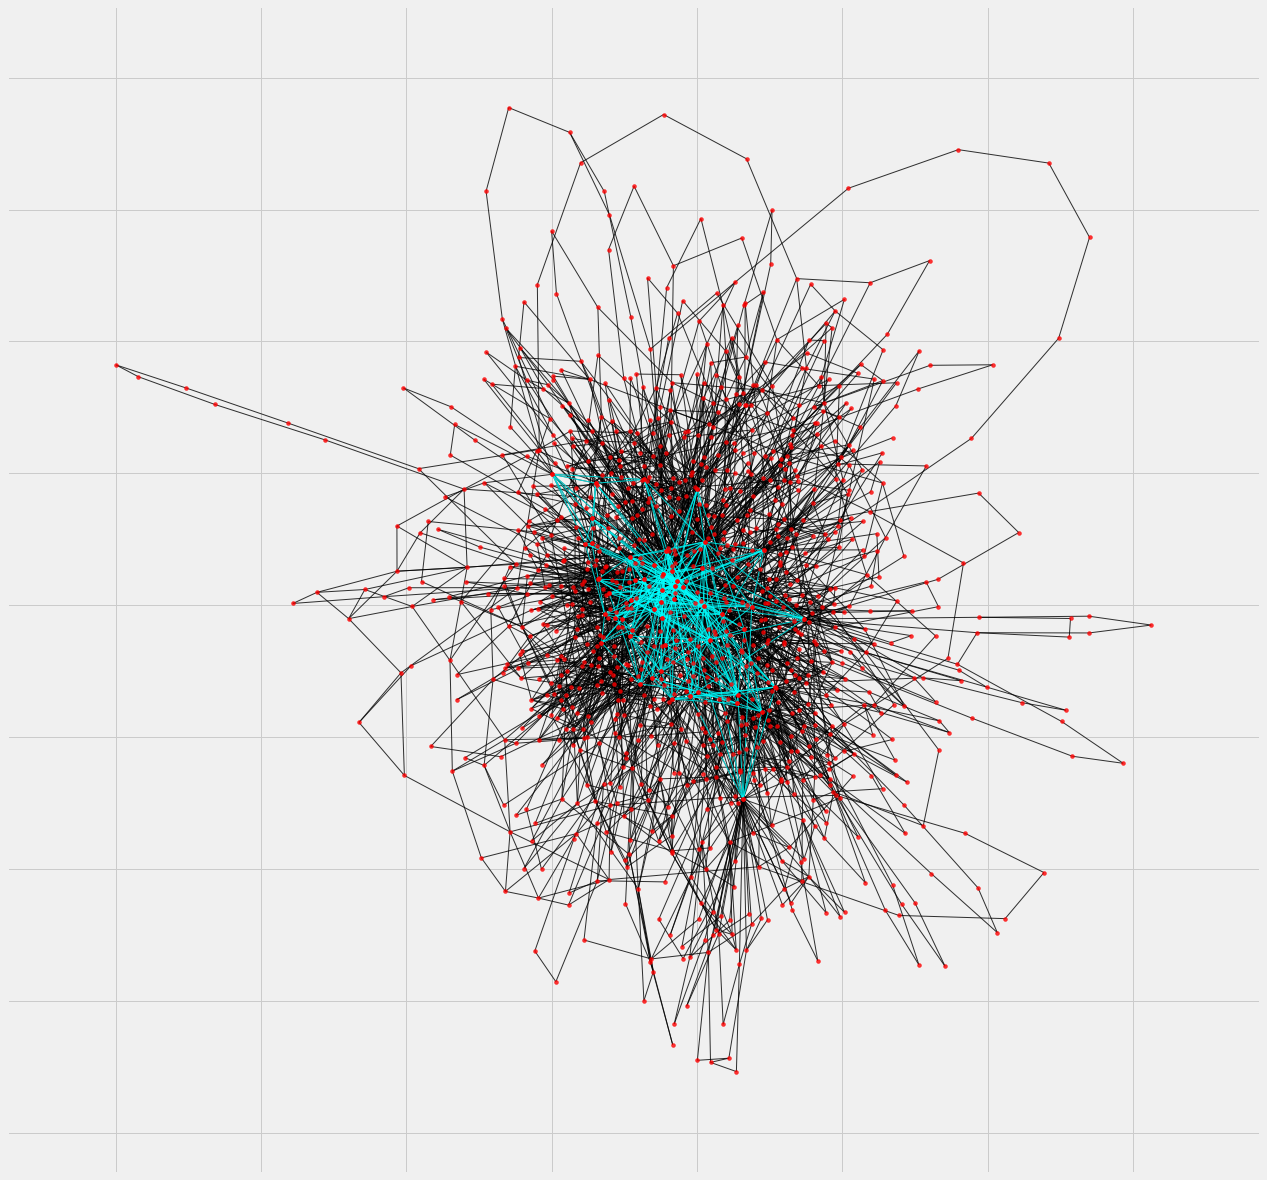

In [49]:
# grafico k kore = 6
nx.draw_networkx(
    G_pesato, pos=pos, node_size=15, edge_color="black", alpha=0.8, with_labels=False,node_color="red")
nx.draw_networkx(
    G_core_6, pos=pos, node_size=15, edge_color="cyan", alpha=0.8, with_labels=False,node_color="red")
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

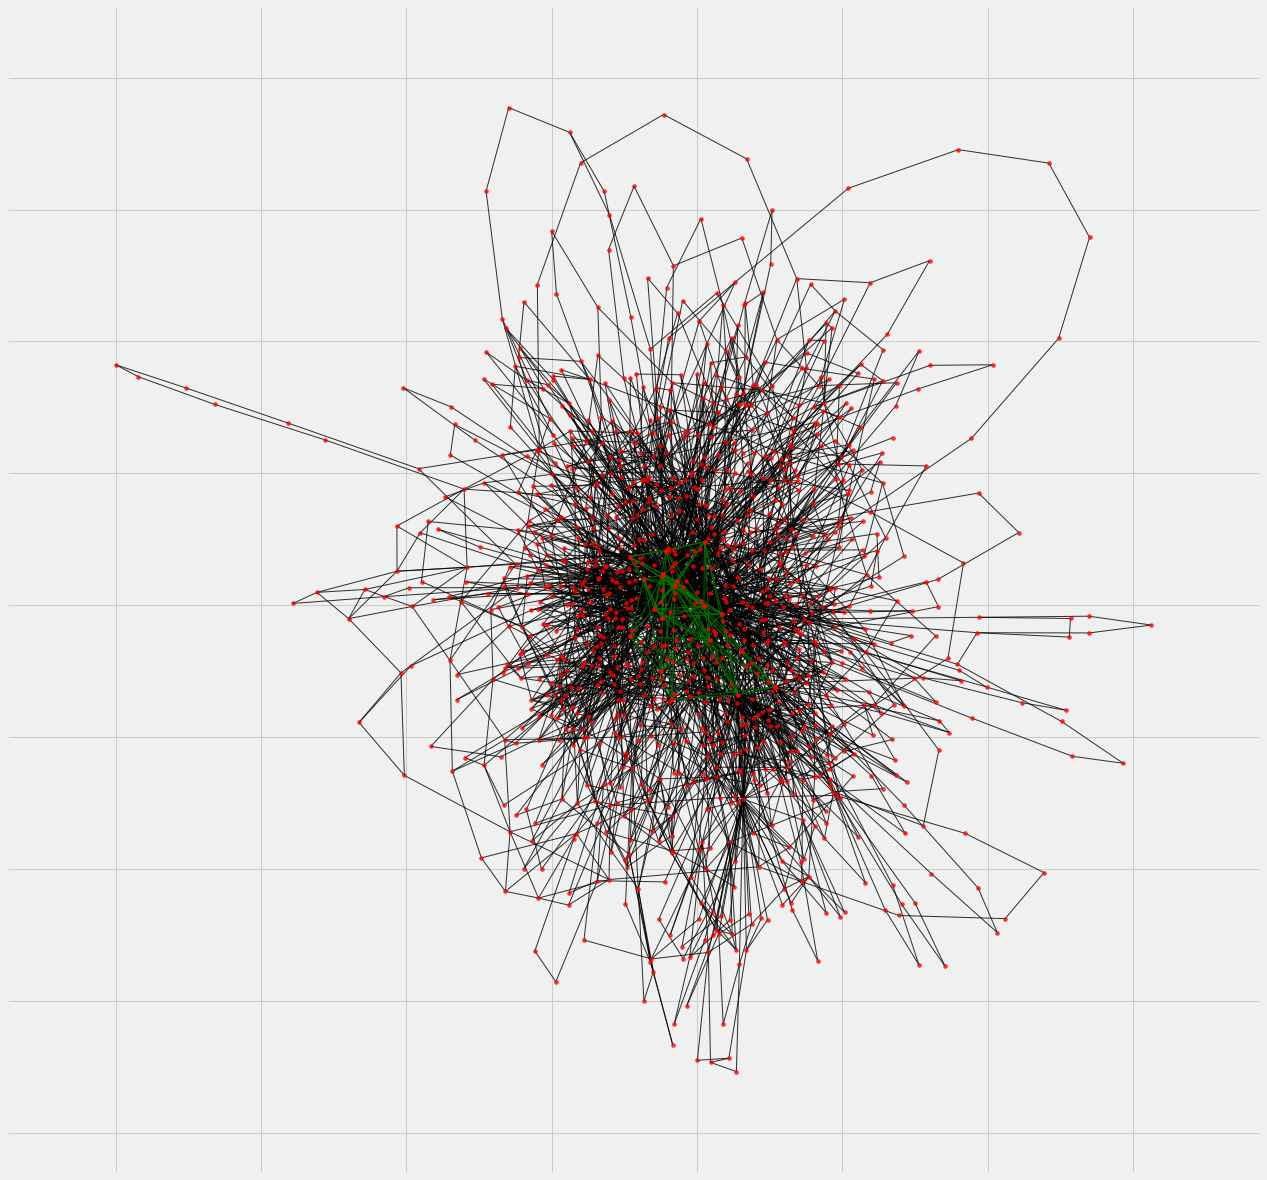

In [48]:
#grafico k kore = 7
nx.draw_networkx(
    G_pesato, pos=pos, node_size=15, edge_color="black", alpha=0.8, with_labels=False,node_color="red")
nx.draw_networkx(
    G_core_7, pos=pos, node_size=15, edge_color="green", alpha=0.8, with_labels=False,node_color="red")
plt.rcParams["figure.figsize"] = (20,20)

In [50]:
def tie_strength(G, v, w):
    # Get neighbors of nodes v and w in G
    v_neighbors = set(G.neighbors(v))
    w_neighbors = set(G.neighbors(w))
    # Return size of the set intersection
    return 1 + len(v_neighbors & w_neighbors)

strength = dict(
    ((v,w), tie_strength(G_pesato, v, w))
    for v, w in G_pesato.edges())

def bridge_span(G):
    # Get list of edges
    edges = G.edges()
    # Copy G
    G = nx.Graph(G)
    # Create result dict
    result = dict()
    for v, w in edges:
        # Temporarily remove edge
        G.remove_edge(v, w)
        # Find distance with edge removed
        try:
            d = nx.shortest_path_length(G, v, w)
            result[(v, w)] = d
        except nx.NetworkXNoPath:
            result[(v, w)] = float('inf')
        # Restore edge
        G.add_edge(v, w)
    return result

span = bridge_span(G_pesato)

In [51]:
# edges ordinati per tie strength
ordered_edges = sorted(strength.items(), key=lambda x: x[1])
print('Edge\t  Strength\tSpan')

for e, edge_strength in ordered_edges:
    print('{}\t{}\t{}'.format(
        str(e), edge_strength, span[e]
    ))

Edge	  Strength	Span
('Afzalgunj.Bus.Stop', 'Gokhle.Nagar')	1	4
('Afzalgunj.Bus.Stop', 'Kokapeta.Lake')	1	3
('Afzalgunj.Bus.Stop', 'Mannyaguda')	1	3
('Afzalgunj.Bus.Stop', 'Dasrlapally')	1	3
('Afzalgunj.Bus.Stop', 'J.P.Durgah')	1	4
('CBS.Bus.Stop', 'Suraram')	1	3
('Charminar.Bus.Stop', 'A.G.Colony')	1	3
('Charminar.Bus.Stop', 'Babika.Chasma(Charminar)')	1	3
('Charminar.Bus.Stop', 'Doodh.Bowli')	1	inf
('Charminar.Bus.Stop', 'Bahadurpally')	1	3
('Charminar.Bus.Stop', 'HAL.Colony')	1	3
('Charminar.Bus.Stop', 'Santhosh.Nagar.Bus.Stand')	1	3
('Charminar.Bus.Stop', 'Lalitha.Bagh')	1	3
('Charminar.Bus.Stop', 'Teegala.Kunta')	1	3
('Charminar.Bus.Stop', 'Rajanna.Bai')	1	3
('Charminar.Bus.Stop', 'LB.Nagar.Bus.Sto')	1	3
('Charminar.Bus.Stop', 'Hafiz.Baba.Nagar')	1	4
('Charminar.Bus.Stop', 'Baba.Nagar')	1	3
('Charminar.Bus.Stop', 'Jalapalli')	1	3
('Charminar.Bus.Stop', 'Kalwakurthy.Bus.Stop')	1	3
('LB.Nagar.Bus.Stop', 'FCI.Colony')	1	3
('LB.Nagar.Bus.Stop', 'Laxmiguda')	1	3
('LB.Nagar.Bus.Stop', '

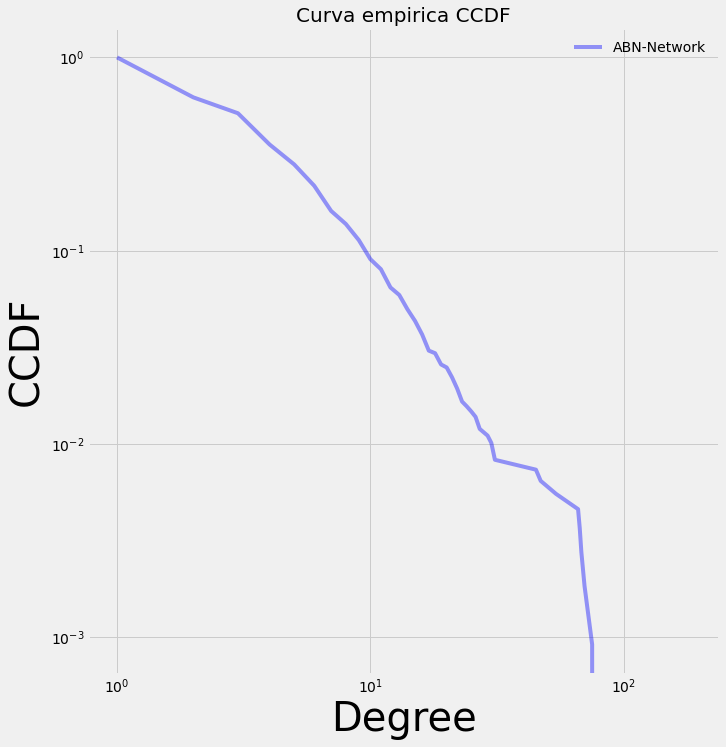

In [36]:
# grafico ccdf
degrees = [G_pesato.degree(u) for u in G_pesato]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, label="ABN-Network")
decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.title("Curva empirica CCDF", fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()


# Random Network Erdos-Renyi

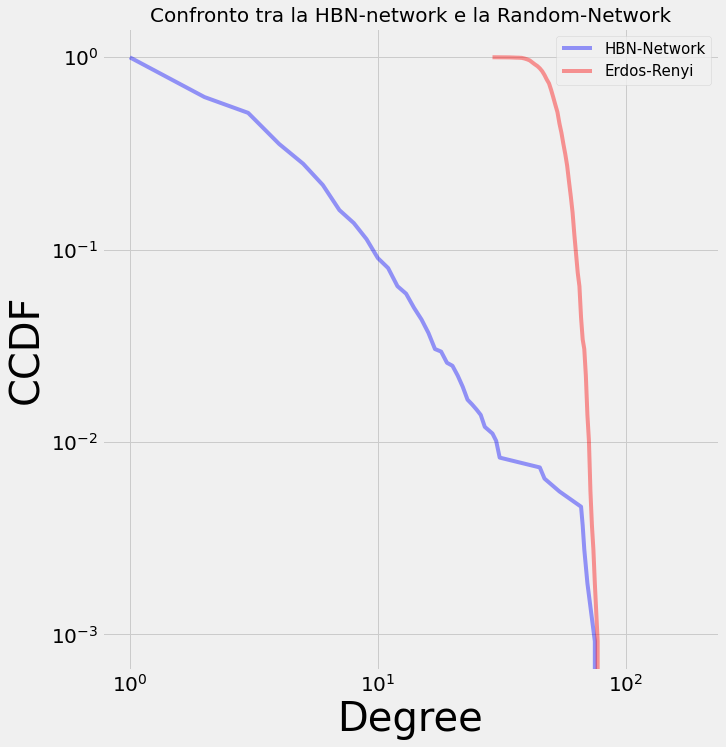

Average degree Random Network: 53.93364055299539
Average degree HBN Network: 5.4396313364055295
Il global clustering della network HBN è:  0.102
Il global clustering della random network è:  0.05
L'APL della network HBN è:  6.679
L'APL della random network è:  2.016


In [37]:
erdos_renyi=nx.erdos_renyi_graph(len(G_pesato),0.05,seed=1)
degrees_er = [erdos_renyi.degree(i) for i in erdos_renyi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, xlabel='Degree', ylabel="CCDF", label="HBN-Network")


cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Renyi")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la HBN-network e la Random-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Random Network:",sum(dict(erdos_renyi.degree()).values())/len(erdos_renyi))
print("Average degree HBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network HBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della random network è: ",(round(nx.transitivity(erdos_renyi),3)))
print("L'APL della network HBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL della random network è: ",(round(nx.average_shortest_path_length(erdos_renyi),3)))


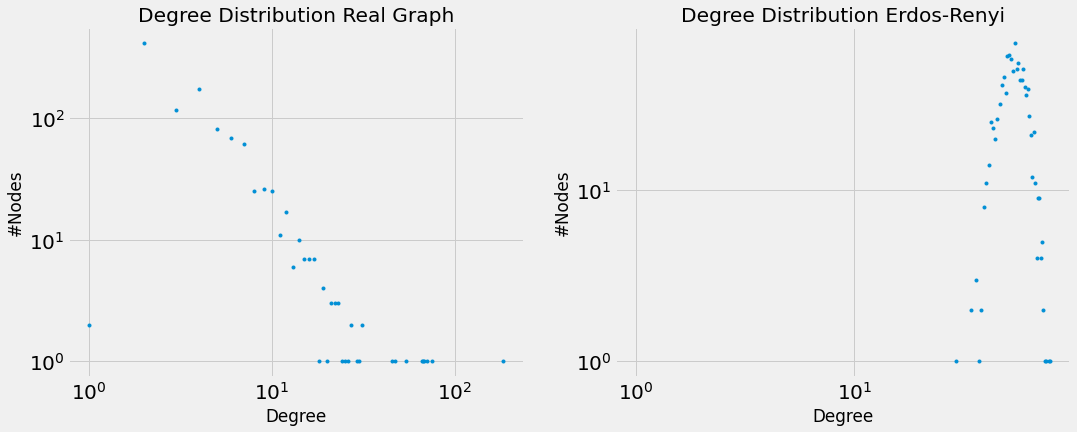

In [38]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(erdos_renyi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Erdos-Renyi")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Small word Watts-Strogatz

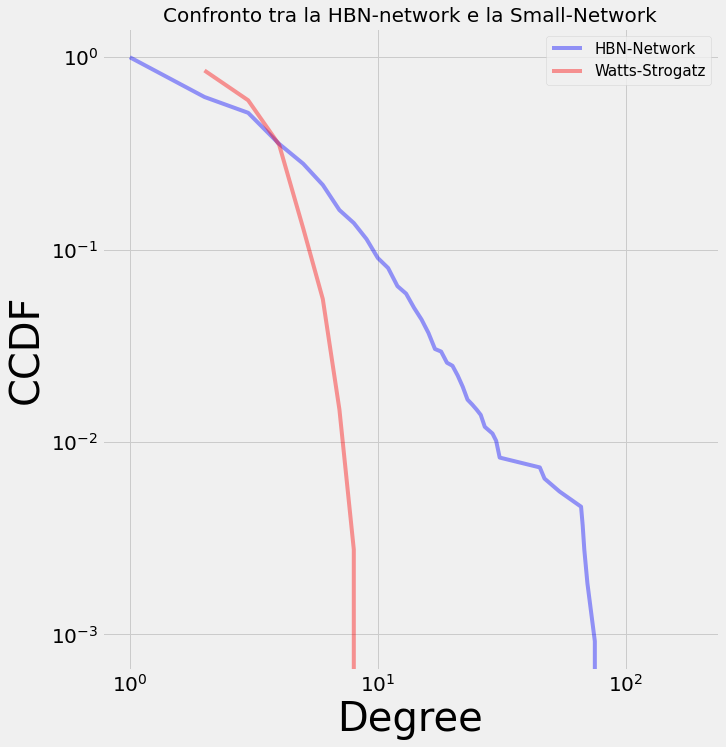

Average degree Small word: 4.0
Average degree HBN Network: 5.4396313364055295
Il global clustering della network HBN è:  0.102
Il global clustering della Small word network è:  0.004
L'APL della network HBN è:  6.679
L'APL della small word network è:  5.392


In [39]:
watts_strogatz = nx.watts_strogatz_graph(len(G_pesato.nodes), int(round(2*len(G_pesato.edges())/len(G_pesato))), 1, seed=1)
degrees_ws = [watts_strogatz.degree(i) for i in watts_strogatz]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="HBN-Network")


cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Watts-Strogatz")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la HBN-network e la Small-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Small word:",sum(dict(watts_strogatz.degree()).values())/len(watts_strogatz))
print("Average degree HBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network HBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della Small word network è: ",(round(nx.transitivity(watts_strogatz),3)))
print("L'APL della network HBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL della small word network è: ",(round(nx.average_shortest_path_length(watts_strogatz),3)))

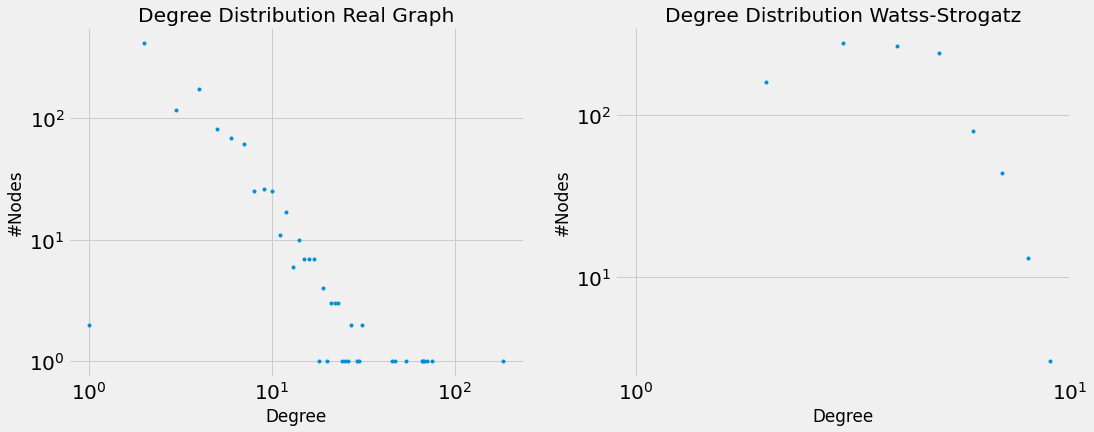

In [40]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(watts_strogatz)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Watss-Strogatz")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Barabasi Albert

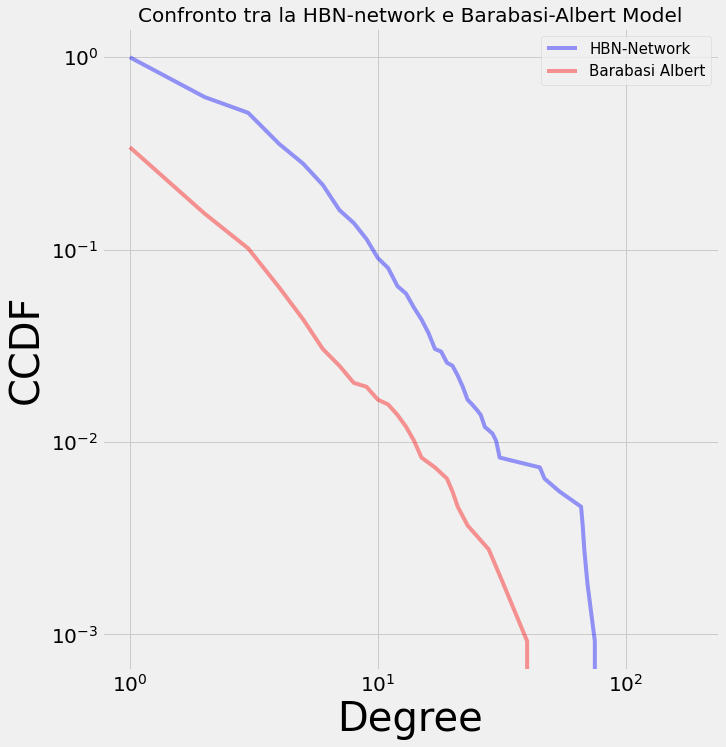

Average degree Barabasi-Albert: 1.9981566820276497
Average degree HBN Network: 5.4396313364055295
Il global clustering della network HBN è:  0.102
Il global clustering del modello di Barabasi-Albert è:  0
L'APL della network HBN è:  6.679
L'APL del modello di Barabasi- Albert è:  7.038


In [41]:
barabasi = nx.barabasi_albert_graph(len(G_pesato.nodes), 1,seed=1)
degrees_barabasi = [barabasi.degree(i) for i in barabasi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="HBN-Network")


cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la HBN-network e Barabasi-Albert Model", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Barabasi-Albert:",sum(dict(barabasi.degree()).values())/len(barabasi))
print("Average degree HBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network HBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering del modello di Barabasi-Albert è: ",(round(nx.transitivity(barabasi),3)))
print("L'APL della network HBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL del modello di Barabasi- Albert è: ",(round(nx.average_shortest_path_length(barabasi),3)))

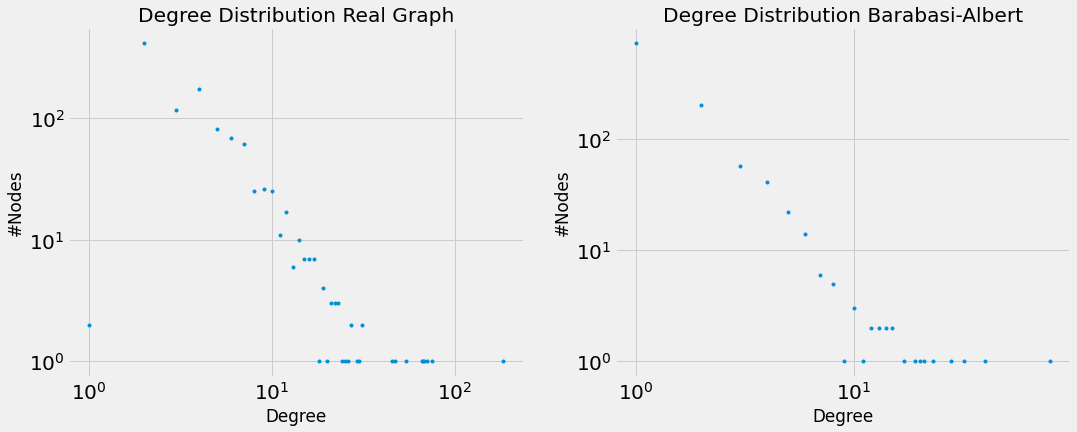

In [42]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(barabasi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Barabasi-Albert")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Confronto tra i vari modelli della CCDF

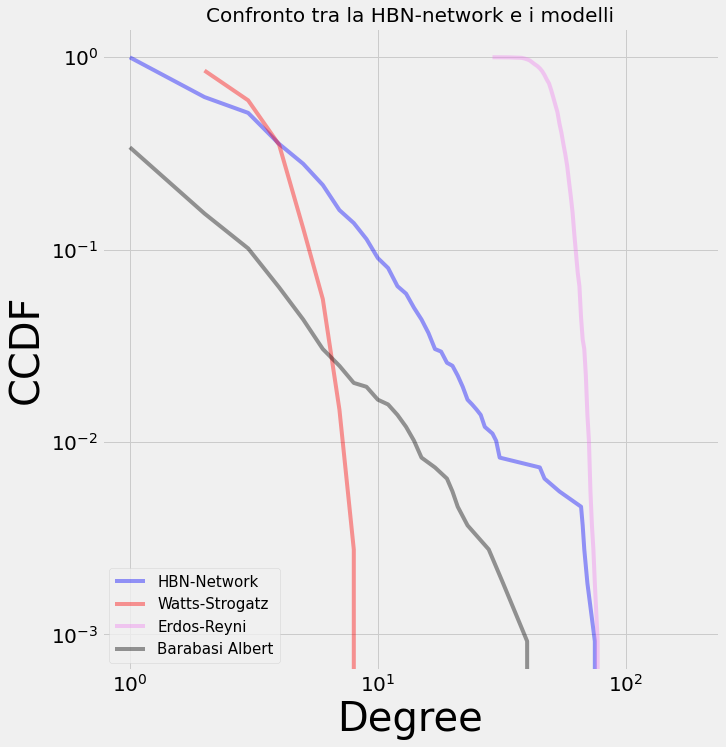

In [43]:
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="HBN-Network")

cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Watts-Strogatz")

cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='violet', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Reyni")

cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='black', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
plt.legend(["HBN-Network","Watts-Strogatz","Erdos-Renyi","Barabasi-Albert"])
plt.title("Confronto tra la HBN-network e i modelli", fontsize=20)
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.legend(fontsize=15)
plt.show()